In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import os, random, librosa
from tqdm.auto import tqdm
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from keras.preprocessing.image import ImageDataGenerator
sns.set_style('darkgrid')

In [2]:
class config:
    CLASSES = np.array(['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'])
    MAX_EPOCHS = 500

# Data Preparation
These audio files are 1 sec long and have a sample rate 16000 ie the audio is sampled 16000 times per second. `read_and_pad_sound_wave` function readds the sound file and ensures the length of the file is consistent (1sec in this case) and returns the signal along with its sample rate

We'll convert the waveform into a mel spectrogram, which shows frequency changes over time and can be represented as a 2D image, which will be used as an input to the CNN, `sound_wave_to_mel_spectrogram` converts an audio into a mel spectrogram of the required dimesnsions


In [3]:
def read_and_pad_sound_wave(filepath, audio_length=16000):
    waveform, sr = sf.read(filepath)
    zero_padding = np.zeros([audio_length - len(waveform)])
    waveform = np.concatenate([waveform, zero_padding], 0)
    return waveform, sr

def sound_wave_to_mel_spectrogram(sound_wave, sample_rate, spec_h=128, spec_w=128, length=1):
    NUM_MELS = spec_h
    HOP_LENGTH = int(sample_rate * length / (spec_w - 1)) 
    mel_spec = librosa.feature.melspectrogram(y=sound_wave, sr=sample_rate, hop_length=HOP_LENGTH, n_mels=NUM_MELS)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

class_distribution = []
spectrogram_samples = []
audio_samples = []

ROOT = '../input/speech-commands-classification-dataset'
DATA = 'mel_spectrograms'
if not os.path.exists(DATA):
    os.mkdir(DATA)
      
for label in tqdm(config.CLASSES):
    src_dir = os.path.join(ROOT, label)
    dst_dir = os.path.join(DATA, label)
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)
        
    for i, filename in enumerate(os.listdir(src_dir)):
        class_distribution.append(label)
        src_path = os.path.join(src_dir, filename)
        dst_path = f"{os.path.join(dst_dir, filename[:-4])}.png"
        plt.imsave(dst_path, sound_wave_to_mel_spectrogram(*read_and_pad_sound_wave(src_path)), cmap='gray')
        if i == 0:
            spectrogram_samples.append(dst_path)
            audio_samples.append(src_path)
print('done')            


done


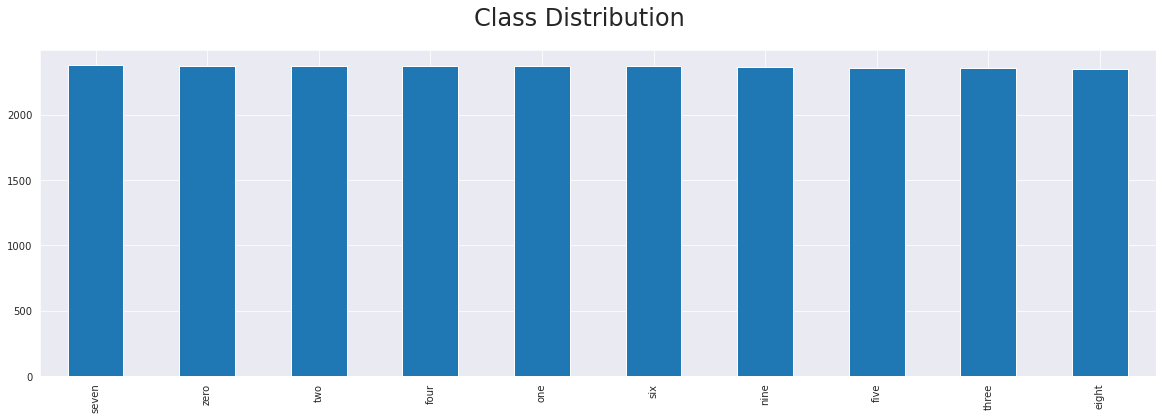

In [4]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.Series(class_distribution).value_counts().plot.bar()
fig.suptitle('Class Distribution', fontsize=24);

# Sample Audio

In [5]:
for i in range(10):
    display.display(display.Audio(read_and_pad_sound_wave(audio_samples[i])[0], rate=16000))

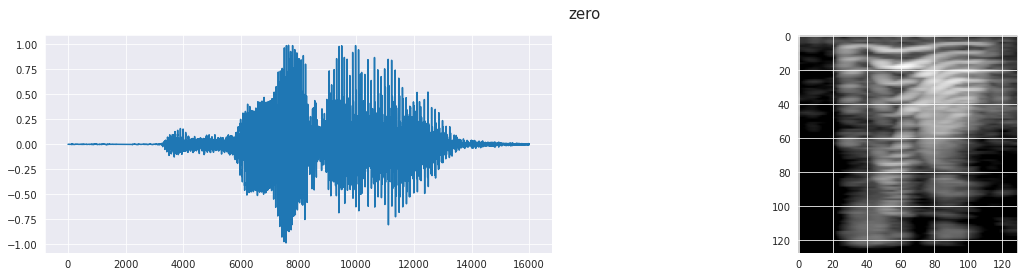

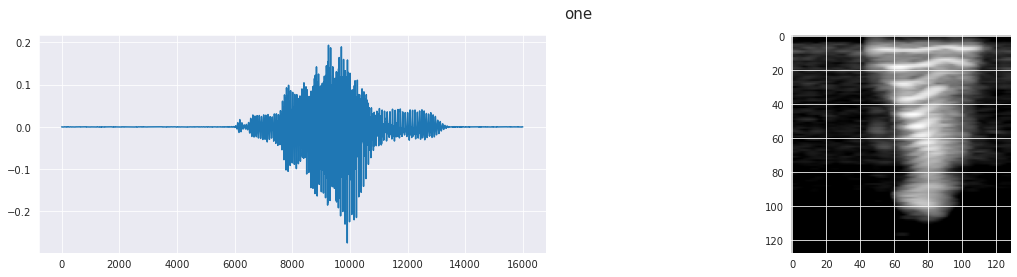

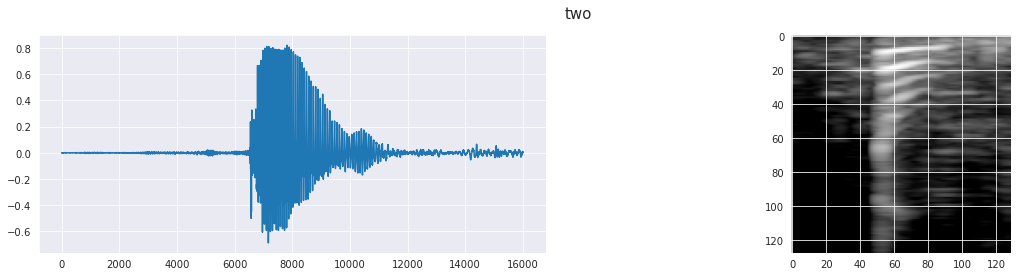

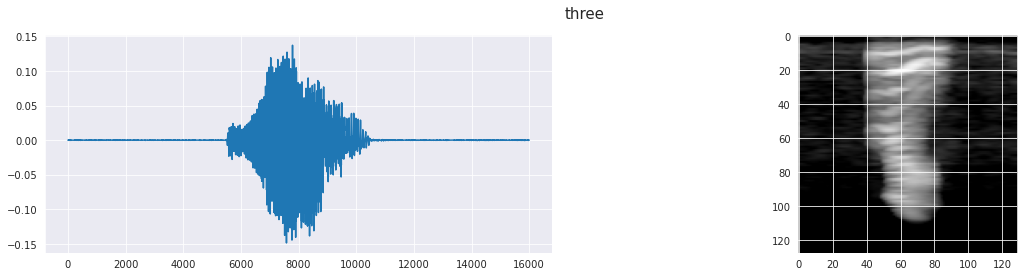

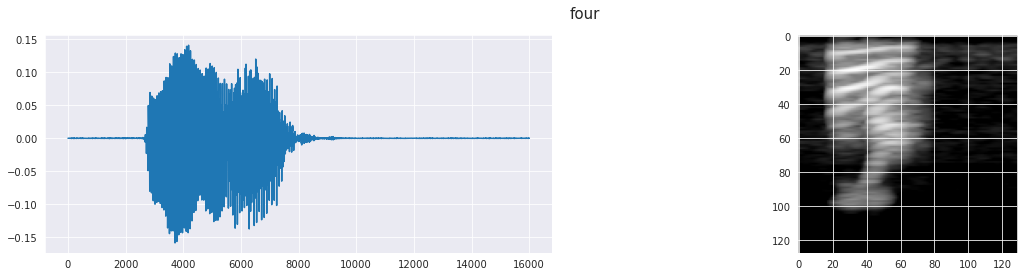

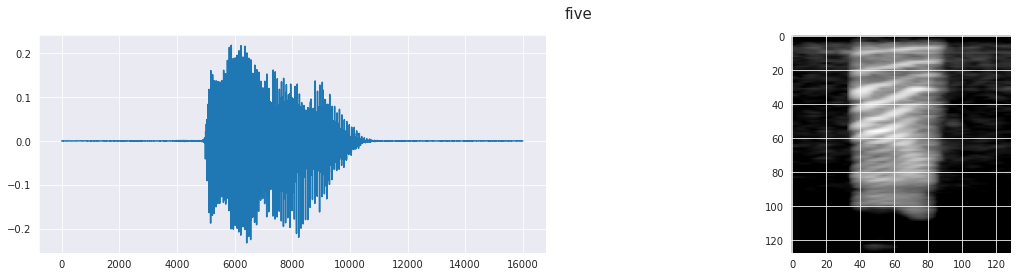

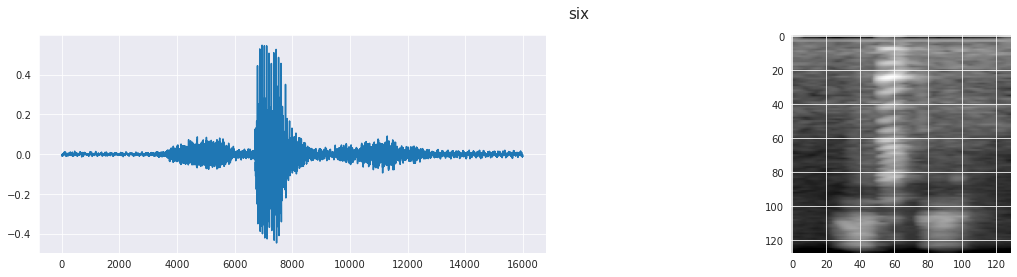

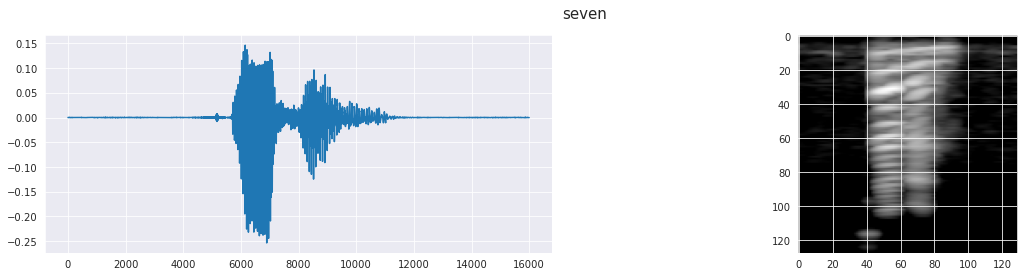

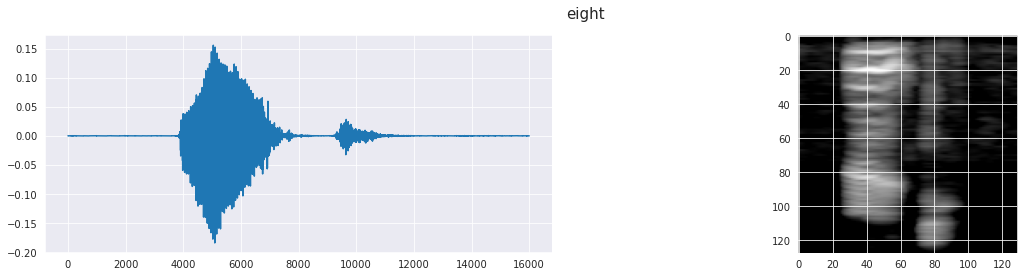

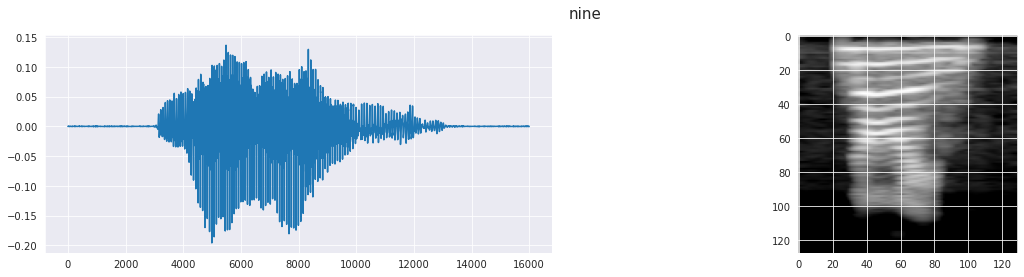

In [6]:
for i in range(10):
    fig, ax = plt.subplots(1,2, figsize=(20, 4))
    ax[0].plot(read_and_pad_sound_wave(audio_samples[i])[0])
    ax[1].imshow(plt.imread(spectrogram_samples[i]), cmap='gray')
    fig.suptitle(config.CLASSES[i], fontsize=15);

# Data Generator

In [7]:
image_size = (128, 128, 1)
datagen = ImageDataGenerator(validation_split=0.1)

training_set = datagen.flow_from_directory(
    DATA, target_size=image_size[:2],  batch_size=32, class_mode='categorical', color_mode='grayscale', subset='training'
)
validation_set = datagen.flow_from_directory(
    DATA, target_size=image_size[:2],  batch_size=32, class_mode='categorical', color_mode='grayscale', subset='validation'
)

Found 21304 images belonging to 10 classes.
Found 2362 images belonging to 10 classes.


# Modellling

In [8]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation='relu', input_shape=image_size, padding='same'),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(padding='same'),
    layers.Dropout(0.25),
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(config.CLASSES), activation='softmax'),
])

model.summary()
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

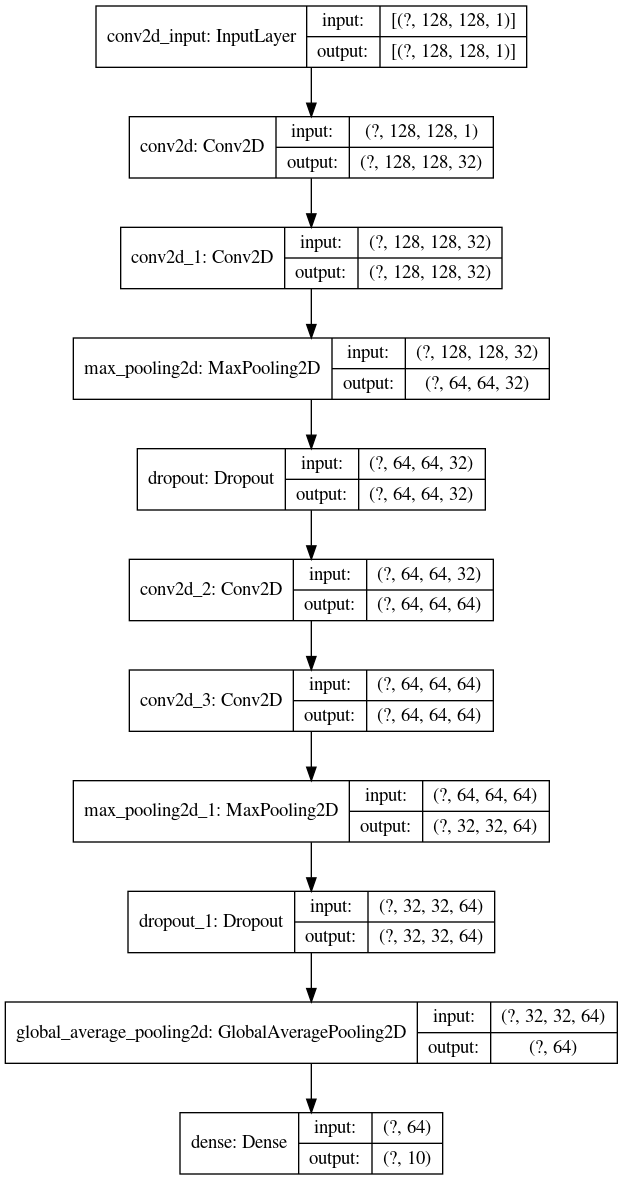

In [9]:
utils.plot_model(model, show_shapes=True, expand_nested=True)

In [10]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-10, mode='min', verbose=1)

history = model.fit(
    training_set, validation_data=validation_set,
    epochs=config.MAX_EPOCHS, callbacks=[es, rlp], batch_size=8
)

Epoch 1/500
666/666 [==============================] - 26s 39ms/step - loss: 2.2420 - accuracy: 0.1849 - val_loss: 2.0221 - val_accuracy: 0.2604
Epoch 2/500
666/666 [==============================] - 26s 39ms/step - loss: 1.8970 - accuracy: 0.3211 - val_loss: 1.8339 - val_accuracy: 0.3417
Epoch 3/500
666/666 [==============================] - 26s 39ms/step - loss: 1.6613 - accuracy: 0.4208 - val_loss: 1.5904 - val_accuracy: 0.4555
Epoch 4/500
666/666 [==============================] - 26s 39ms/step - loss: 1.3731 - accuracy: 0.5347 - val_loss: 1.1790 - val_accuracy: 0.6291
Epoch 5/500
666/666 [==============================] - 26s 39ms/step - loss: 1.0718 - accuracy: 0.6526 - val_loss: 0.9168 - val_accuracy: 0.7036
Epoch 6/500
666/666 [==============================] - 25s 38ms/step - loss: 0.8652 - accuracy: 0.7290 - val_loss: 0.7356 - val_accuracy: 0.7650
Epoch 7/500
666/666 [==============================] - 26s 39ms/step - loss: 0.7167 - accuracy: 0.7745 - val_loss: 0.9006 - val_ac

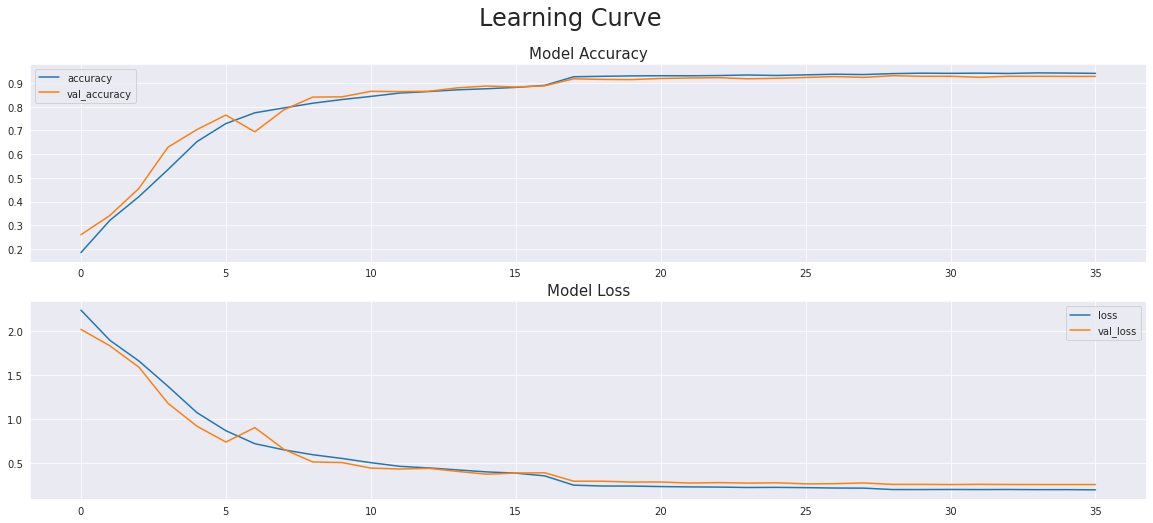

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df = pd.DataFrame(history.history)
df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=15)
ax[1].set_title('Model Loss', fontsize=15)
fig.suptitle('Learning Curve', fontsize=24);